# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [6]:
df = pd.read_csv('../data/engineered_features.csv', parse_dates=['date'], index_col='date')
df.head()

,spx_close,vix,dgs10,fedfunds,cpi,unrate,spx_ret,rv_21d_pct,vrp_ratio,rate_shock_5d_bps
date,,,,,,,,,,
2020-10-23,0.070698,0.387695,0.85,0.09,260.319,6.9,0.053491,721.180880,-0.999462,9.0
2020-10-26,0.050764,0.509019,0.81,0.09,260.319,6.9,-0.331233,395.760560,-0.998714,3.0
2020-10-27,0.047580,0.531011,0.79,0.09,260.319,6.9,-0.064779,337.028035,-0.998424,-2.0
2020-10-28,0.010555,0.702249,0.79,0.09,260.319,6.9,-1.505799,624.620781,-0.998876,-4.0
2020-10-29,0.022648,0.635780,0.85,0.09,260.319,6.9,0.763468,678.915848,-0.999064,-2.0


## Option B: Synthetic Generator (Use if you don't have data ready)

In [ ]:
# Synthetic series with regimes & jumps
# n=500
# dates=pd.bdate_range('2021-01-01', periods=n)
# mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
# sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
# eps = np.random.normal(mu, sigma)
# jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
# jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
# rets = eps + jumps
# price = 100*np.exp(np.cumsum(rets))
# df = pd.DataFrame({'price':price}, index=dates)
# df['ret'] = df['price'].pct_change().fillna(0.0)
# df['log_ret'] = np.log1p(df['ret'])
# df.head()

## Feature Engineering

In [7]:
df['lag_1'] = df['spx_ret'].shift(1)
df['lag_5'] = df['spx_ret'].shift(5)
df['roll_mean_5'] = df['spx_ret'].rolling(5).mean().shift(1)
df['roll_vol_20'] = df['spx_ret'].rolling(20).std().shift(1)
df['y_next_ret'] = df['spx_ret'].shift(-1)  # regression target
df['y_up'] = (df['y_next_ret'] > 0).astype(int)  # classification target
df_feat = df.dropna().copy()
df_feat.head()

,spx_close,vix,dgs10,fedfunds,cpi,unrate,spx_ret,rv_21d_pct,vrp_ratio,rate_shock_5d_bps,lag_1,lag_5,roll_mean_5,roll_vol_20,y_next_ret,y_up
date,,,,,,,,,,,,,,,,
2020-11-20,0.099213,0.292562,0.83,0.09,260.319,6.9,-0.073143,789.839097,-0.999630,-6.0,0.041674,0.148780,0.027863,0.510021,0.060658,1
2020-11-23,0.105418,0.266864,0.86,0.09,260.319,6.9,0.060658,789.882795,-0.999662,-5.0,-0.073143,0.113258,-0.016521,0.510412,0.156768,1
2020-11-24,0.123310,0.241660,0.88,0.09,260.319,6.9,0.156768,780.652847,-0.999690,1.0,0.060658,-0.045588,-0.027041,0.503822,-0.014560,0
2020-11-25,0.121527,0.232024,0.88,0.09,260.319,6.9,-0.014560,779.978772,-0.999703,0.0,0.156768,-0.118807,0.013430,0.503912,0.021911,1
2020-11-27,0.124219,0.221893,0.84,0.09,260.319,6.9,0.021911,539.941362,-0.999589,-2.0,-0.014560,0.041674,0.034279,0.348244,-0.042544,0


## Split

In [9]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1', 'lag_5', 'roll_mean_5', 'roll_vol_20']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

RMSE: 0.029366214293906977


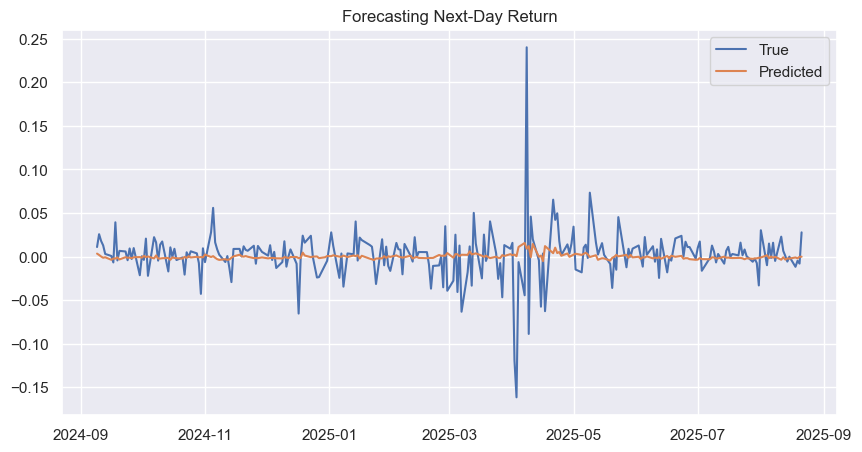

In [11]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred_reg = reg.predict(X_te)
# rmse = mean_squared_error(y_te_reg, pred_reg, squared=False)
mse  = mean_squared_error(y_te_reg, pred_reg)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

plt.figure(figsize=(10,5))
plt.plot(y_te_reg.index, y_te_reg, label='True')
plt.plot(y_te_reg.index, pred_reg, label='Predicted')
plt.legend()
plt.title('Forecasting Next-Day Return')
plt.show()

              precision    recall  f1-score   support

           0       0.17      0.01      0.02       103
           1       0.56      0.96      0.71       136

    accuracy                           0.55       239
   macro avg       0.36      0.49      0.36       239
weighted avg       0.39      0.55      0.41       239



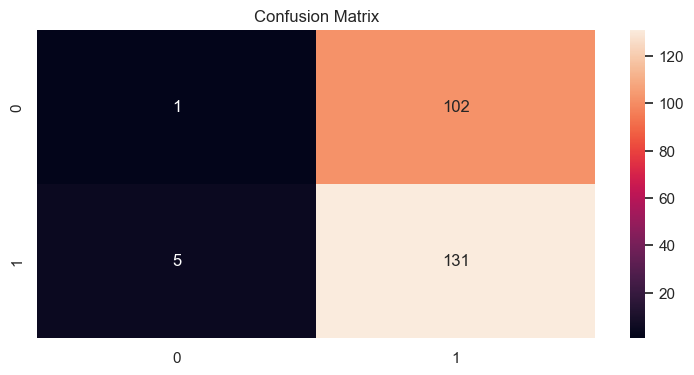

In [12]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
pred_clf = clf.predict(X_te)
print(classification_report(y_te_clf, pred_clf))
cm = confusion_matrix(y_te_clf, pred_clf)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

## Interpretation (Markdown)
- **What worked?**:
    - The regression model achieves a relatively low RMSE (0.029), meaning that the predictions are not wildly off in magnitude. However, by looking at the plot, the predicted series fails to capture the sharp spikes in returns.
    - The classification model achieves about 55% accuracy, but it mostly predicts "up" days, indicating that the classifier is heavily biased toward "up". This gives very high recall for up moves (0.96) but poor performance on down moves. 
- **Where might assumptions fail?**:
    - The regression model assumes linear relationships, but market returns are noisy, fat-tailed, and often driven by rare shocks that linear models cannot capture.
    - Both models assume short-term autocorrelation in returns, but financial markets are often close to a random walk, limiting predictability. 
- **How would you extend features or model?**:
    - Try nonlinear models to capture nonlinear dependencies missed by logistic regression and linear regression.
    - Add macro features as predictors.

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.